# Introduction CNNs to Decode ECoG Data
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_02_CNN_faces_houses.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_02_CNN_faces_houses.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-rc0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [2]:
# Additional imports and configs
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras

plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one participant
See 02_02 for an explanation.
However, this time we are loading the full-band time-domain data at the original sampling rate (1 kHz), with [limited preprocessing](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/kjm_ecog/03_convert.py#L67-L93).

### Load the data
This time we're using a helper function from the repo. You can see the code [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py#L92),
but it's essentially the same as what we used in 02_02.

In [4]:
from data.utils.fileio import load_faces_houses

SUB_ID = 'mv'
X, Y, ax_info = load_faces_houses(datadir, SUB_ID, feature_set='full')
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 603 trials, 801 timestamps (-0.2 to 0.6 at 1000 Hz), 58 channels


### Get baseline accuracy
Remember, the signals haven't been processed much. The only features we can expect LDA to pick out are stimulus-evoked time-domain signals. Also with 801 * 58 features, over-fitting is likely. Unfortunately, the LDA 'eigen' solver can't handle this ~600 x ~4800 matrix so we can't use its shrinkage. We'll use regularized logistic regression instead. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's typically used as a classification algorithm.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 5
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 200
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("3-class accuracy: {}".format(pcnt_corr))

Performing 5-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
3-class accuracy: 92.03980099502488


So even with way more features and without signal processing, we're getting fairly high accuracy at ~92%. Our goal is for the deep model to do at least as well, hopefully better, and we expect it will be useful in other ways too.

### Prepare data for deep learning
See 02_02 notebook for explanation.

One major difference from 02_02 notebook is that here we are using [data augmentation](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/). Briefly, we are using a time-domain window of only 701 of our 801 samples and the start of the window (`t_offset`) is random on every step, but only for the training data. For the validation data, we use the last 701 samples only.

For now we only define the functions that will act on the data. The data will be processed when running the model.

In [6]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Create our model
As in 02_02, our model objective is to transform ECoG data into multiclass classification scores.

There are already many models that others have developed for similar purposes:

* [EEG with transfer learning](https://iopscience.iop.org/article/10.1088/1741-2552/aaf3f6)
* [ECoG speech reconstruction](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2018-102.pdf)
    * 2D CNN - channels x timestamps; amplitude data
* [ECoG CNNs with LSTMs](https://iopscience.iop.org/article/10.1088/1741-2552/aa9dbe/meta)
    1. CNN for spatial unmixing matrix [77] initialized with fast ICA
    1. 3 temporal CNN layers, with [2, 4, 8] filters of kernel size 1 x 17 per layer, initialized with biorthogonal wavelet 6.8.
* [ECoG CNNs with autoencoders](https://iopscience.iop.org/article/10.1088/1741-2552/aaf13f/pdf)
* [EEGNet](https://iopscience.iop.org/article/10.1088/1741-2552/aace8c)
    * [source](https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py#L58-L158)
* [EEG CNN with parallel early layers](https://iopscience.iop.org/article/10.1088/1741-2552/ab3bb4)

We are going to use a version of EEGNet with an added set of parallel layers at the beginning.

In [7]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_model(T, C, aug_offset=100, n_classes=3,
               n_temporal_short=7, len_temporal_short=38,
               n_temporal_long=4, len_temporal_long=120,
               D=4,
               activation='relu',
               downsamp_1=5,
               n_pointwise_filters=36,
               len_kernel_2=16, downsamp_2=7,
               norm_rate=0.45, dropout_rate=0.45, l2_reg=0.0002,
               optimizer='Nadam'):

    # Temporal kernel convolutions.
    _input = tf.keras.Input(shape=(T - aug_offset, C, 1))
    
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(_input)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(_input)
    _y = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y = layers.BatchNormalization(axis=1)(_y)
    
    # Spatial Filter
    _y = layers.DepthwiseConv2D((1, C), use_bias=False,
                                depth_multiplier=D,
                                kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                depthwise_constraint=max_norm(1.))(_y)
    # The order of Activation and BathNormalization is switched here compared to EEGNet.
    # This is because we use relu. relu after normalization discards too much data.
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=1)(_y)
    _y = layers.AveragePooling2D((downsamp_1, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    
    # Feature aggregation
    _y = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid',
                                use_bias=False
                               )(_y)
    _y = layers.Activation(activation)(_y)
    _y = layers.BatchNormalization(axis=1)(_y)
    _y = layers.AveragePooling2D((downsamp_2, 1))(_y)
    _y = layers.Dropout(dropout_rate)(_y)
    
    # To class predictions
    _y = layers.Flatten()(_y)
    _y = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(_y)
    _y = layers.Activation('softmax')(_y)
    
    model = tf.keras.Model(inputs=_input, outputs=_y)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model


model = make_model(X.shape[1], X.shape[2], n_classes=len(np.unique(Y)))
model.summary()
reset_keras(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, 58, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, 58, 7)   266         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, 58, 4)   480         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, 58, 11)  0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

## Train the Model

In [8]:
N_SPLITS = 5
BATCH_SIZE = 10
MAX_OFFSET = 100
N_EPOCHS = 80

In [9]:
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
split_ix = 0
best_val_accs = []
hists = []
for trn, tst in splitter.split(X, Y):
    print("Running split {} of {}".format(split_ix + 1, N_SPLITS))
    
    # Get the training/testing data for this split.
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    # Create new model
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET)

    # Callback to save only the best (highest validation accuracy) model weights during training.
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(datadir / 'models' / (SUB_ID + '_model{}_best.h5'.format(split_ix))),
            save_best_only=True,
            monitor='val_accuracy',
            verbose=0)
    ]
    
    # Train model
    history = model.fit(x=ds_train,  
                        epochs=N_EPOCHS, 
                        validation_data=ds_valid,
                        callbacks=callbacks,
                        verbose=0)
    hists.append(history.history)
    
    bva = 100*max(history.history['val_accuracy'])
    print("Split {}: Best validation accuracy {:.2f}%".format(split_ix + 1, bva))
    best_val_accs.append(bva)
    split_ix += 1
    reset_keras(model)

print("%.2f%% (+/- %.2f%%)" % (np.mean(best_val_accs), np.std(best_val_accs)))

best_path = datadir / 'models' / (SUB_ID + '_model{}_best.h5'.format(np.argmax(best_val_accs)))
best_path.replace(datadir / 'models' / (SUB_ID + '_model_best_all.h5'))

# Download 'best' model anytime with
# files.download(datadir / (SUB_ID + '_model_best_all.h5'))

Running split 1 of 5
Split 1: Best validation accuracy 99.17%
18
Running split 2 of 5
Split 2: Best validation accuracy 98.35%
163934
Running split 3 of 5
Split 3: Best validation accuracy 96.69%
163934
Running split 4 of 5
Split 4: Best validation accuracy 95.83%
163934
Running split 5 of 5
Split 5: Best validation accuracy 97.50%
163934
97.51% (+/- 1.18%)


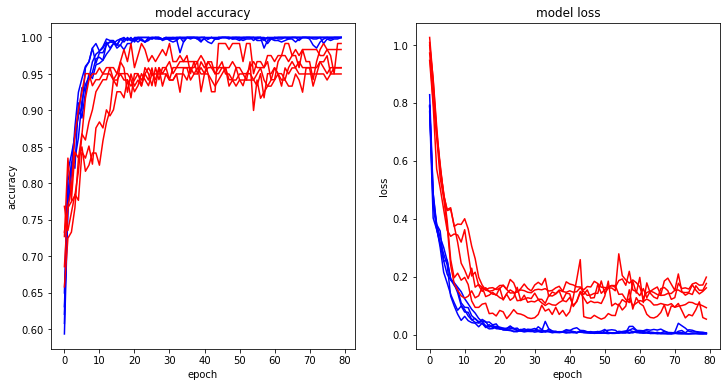

In [10]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(np.vstack([_['accuracy'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_accuracy'] for _ in hists]).T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.vstack([_['loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_loss'] for _ in hists]).T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

##### Using no feature engineering, we achieved 92.2% accuracy using a shallow model. Using a deep model, validation accuracy improved to ~97.5%. This is comparable to the 97.7% accuracy achieved using feature engineering and LDA, but without any expertise or neurophys knowledge required.

## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0, split_seed=0):
    print(params)
    n_temporal_short = params.get('n_temporal_short', 8)
    len_temporal_short = params.get('len_temporal_short', 20)
    n_temporal_long = params.get('n_temporal_long', 8)
    len_temporal_long = params.get('len_temporal_long', 250)
    D = params.get('D', 8)
    downsamp_1 = params.get('downsamp_1', 10)
    n_pointwise_filters = params.get('n_pointwise_filters', 20)
    len_kernel_2 = params.get('len_kernel_2', 32)
    downsamp_2 = params.get('downsamp_2', 2)
    norm_rate = params.get('norm_rate', 0.45)
    dropout_rate = params.get('dropout_rate', 0.45)
    l2_reg = params.get('l2_reg', 0.0002)
    epochs = params.get('epochs', 60)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=split_seed)
    trn, tst = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, trn, tst,
                                                     batch_size=BATCH_SIZE,
                                                     max_offset=MAX_OFFSET)
    
    model = make_model(X.shape[1], X.shape[2], aug_offset=MAX_OFFSET,
                       n_temporal_short=n_temporal_short, len_temporal_short=len_temporal_short,
                       n_temporal_long=n_temporal_long, len_temporal_long=len_temporal_long,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, len_kernel_2=len_kernel_2,
                       downsamp_2=downsamp_2,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    print("Min validation loss with these parameters: {}".format(min_val_loss))
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [ ]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_temporal_short': scope.int(hp.quniform('n_temporal_short', 1, 20, 1)),
    'len_temporal_short': scope.int(hp.quniform('len_temporal_short', 8, 50, 2)),
    'n_temporal_long': scope.int(hp.quniform('n_temporal_long', 1, 15, 1)),
    'len_temporal_long': scope.int(hp.quniform('len_temporal_long', 60, 250, 5)),
    'D': scope.int(hp.quniform('D', 1, 12, 1)),
    'downsamp_1': scope.int(hp.quniform('downsamp_1', 4, 10, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
    'len_kernel_2': scope.int(hp.quniform('len_kernel_2', 4, 64, 1)),
    'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 9, 1)),
#     'norm_rate': hp.uniform('norm_rate', 0., 0.5),
#     'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
#     'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
eval_hours = 7.5
minutes_per_eval = 0.5
max_evals = int(eval_hours * 60 / minutes_per_eval)
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

In [ ]:
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

In [ ]:
def scatterplot_matrix_colored(params_names, params_values, best_losses,
                               transform='none'):
    """Scatterplot colored according to the Z values of the points."""
    import matplotlib
    
    nb_params = len(params_values)
    best_losses = np.array(best_losses)
    best_trial = np.argmin(best_losses)
    
    if transform == 'inv':
        best_losses = 1 / best_losses
    elif transform == '-log':
        best_losses = -np.log(best_losses)
        
    norm = matplotlib.colors.Normalize(vmin=best_losses.min(), vmax=best_losses.max())
    
    fig, ax = plt.subplots(nb_params, nb_params, figsize=(16, 16), facecolor='white')
    
    for i in range(nb_params):
        p1 = params_values[i]
        for j in range(nb_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            axes.axvline(p2[best_trial], color='r', zorder=-1, alpha=0.3)
            axes.axhline(p1[best_trial], color='r', zorder=-1, alpha=0.3)
                
            # Subplot:
            s = axes.scatter(p2, p1, s=30, alpha=0.3,
                             c=best_losses, cmap=turbo_cmap, norm=norm)

            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=0)
            else:
                axes.set_yticks([])
            
            if i == nb_params - 1:
                axes.set_xlabel(params_names[j], rotation=90)
            else:
                axes.set_xticks([])

    fig.subplots_adjust(right=0.82, top=0.95)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of -log valid. loss over different param values')
    plt.show()

hp_loss = np.array([_['result']['loss'] for _ in trials.trials])
hp_names = list(space.keys())
hp_vals = [[_['misc']['vals'][key][0] for _ in trials.trials] for key in hp_names]
if 'l2_reg' in hp_names:
    hp_vals[hp_names.index('l2_reg')] = np.log10(hp_vals[hp_names.index('l2_reg')])
scatterplot_matrix_colored(hp_names, hp_vals, hp_loss, transform='-log')
print(np.min(hp_loss))